# Train a Diffusion Mode with 🤗 Diffusers

## 이 파일에서 학습할 내용

- PoC(Proof of Concept)를 위한 간단한 이미지 생성 모델을  MNIST를 사용하여 밑바닥부터 학습

- 🤗 Diffusers에서 제공하는 UNet2D 모델 심층 분석




## Step 1: Setup

- 다음 셀을 실행하여 디퓨저 라이브러리와 몇 가지 다른 요구 사항을 설치

In [2]:
# !pip install -qU diffusers

In [3]:
import diffusers

diffusers.__version__

'0.31.0'

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

- 디바이스 세팅

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Step 2: Prepare a training dataset

- pytorch로 부터 MNIST데이터 셋 다운로드

- 이미지 배치를 그리드 형태로 바꿔 표시할 보조 함수 정의

In [6]:
def show_images(x, return_type='PIL'):
    """Given a batch of images x, make a grid and convert to PIL"""

    # Map from (-1, 1) back to (0, 1)
    x = x * 0.5 + 0.5

    # (B x C x H x W) -> (C x H x W)인 이미지를 (B/nrow, nrow)인 격자형태로.
    # Default nrow: 8
    # 1채널 이미지가 입력되도 반환은 3채널로 됨
    grid = torchvision.utils.make_grid(x)

    #                             ch last,         (0,1) -> (0,255)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255

    if return_type == 'PIL':
        # PIL 이미지로 리턴하는 경우
        # tensor -> ndarray -> Image
        grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    else:
        # numpy 어레이로 리턴하는 경우
        # tensor -> ndarray
        # ndarray(H,W,C)
        grid_im = np.array(grid_im).astype(np.uint8)

    return grid_im

In [7]:
from torchvision import transforms

image_size = 28
batch_size = 128

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [8]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True,
    transform=preprocess)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 50.9MB/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.95MB/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [9]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([1, 1, 5, 8, 9, 3, 5, 7, 6, 5, 0, 4, 2, 4, 6, 9, 2, 1, 5, 8, 7, 0, 1, 9,
        5, 7, 2, 0, 8, 8, 7, 2, 8, 7, 8, 6, 7, 1, 2, 2, 9, 6, 0, 3, 5, 3, 1, 6,
        3, 4, 0, 0, 3, 2, 0, 2, 4, 6, 9, 6, 0, 3, 0, 3, 2, 7, 7, 4, 6, 3, 7, 3,
        7, 0, 4, 6, 0, 7, 9, 1, 6, 2, 0, 2, 8, 7, 1, 1, 5, 4, 4, 1, 7, 6, 9, 3,
        5, 7, 4, 0, 4, 5, 4, 0, 0, 6, 6, 6, 8, 4, 9, 3, 1, 5, 5, 2, 9, 3, 4, 7,
        4, 8, 7, 8, 7, 5, 7, 7])
<class 'PIL.Image.Image'>


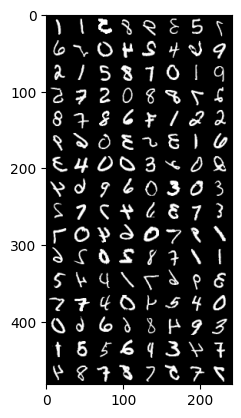

In [10]:
x, y = next(iter(train_dataloader))

print('Input shape:', x.shape)
print('Labels:', y)

grid_imgs = show_images(x)
print(type(grid_imgs))

plt.imshow(grid_imgs)

plt.show()

## Step 3: Define the Scheduler

- Diffusion 모델의 학습은 입력 이미지에 노이즈를 추가한 다음 노이즈 이미지를 모델에 공급하고 이미지에 추가된 노이즈를 예측하는 과정

- 따라서 어떤 스케쥴로 노이즈를 추가하는지도 모델의 학습에 영향을 미침

- DDPM([Denoising Diffusion Probabalistic Models](https://arxiv.org/abs/2006.11239))에서 기본적으로 사용하는 노이즈 스케쥴러를 세팅

In [11]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

X shape: torch.Size([8, 1, 28, 28])


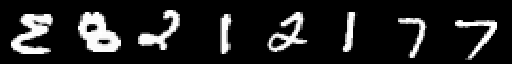

In [12]:
xb = next(iter(train_dataloader))[0].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

timesteps:  tensor([ 59, 790,  89, 340, 100,  90, 940, 890], device='cuda:0')
Noisy X shape torch.Size([8, 1, 28, 28])


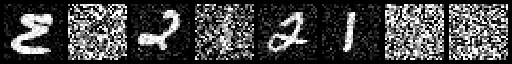

In [13]:
timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (8,)
        ).long().to(device)
print('timesteps: ', timesteps)

noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Step 4: Define the Model

- 노이즈 제거 모델을 직접 만들지 않고 🤗 Diffusers에서 제공하는 아래와 같은 가장 간단한 형태의 UNet 모델을 생성
    - 모델은 입력 이미지가 ResNet 레이어의 여러 블록을 거치도록 하고 각 블록은 이미지 크기를 2로 반으로 줄임
    - 그런 다음 다시 업샘플링하는 동일한 수의 블록을 통해 이미지 크기를 원복
    - 이때 다운 샘플 블록의 피처를 업샘플 블에 연결하는 스킵 연결 존재
    - 모델의 최종 예측은 입력과 동일한 크기의 이미지

- 모델 내부에 self attention이 추가되고 skip connection도 존재하기 때문에 완전히 파악하기 어려움

- 제공된 분석 슬라이드 참고

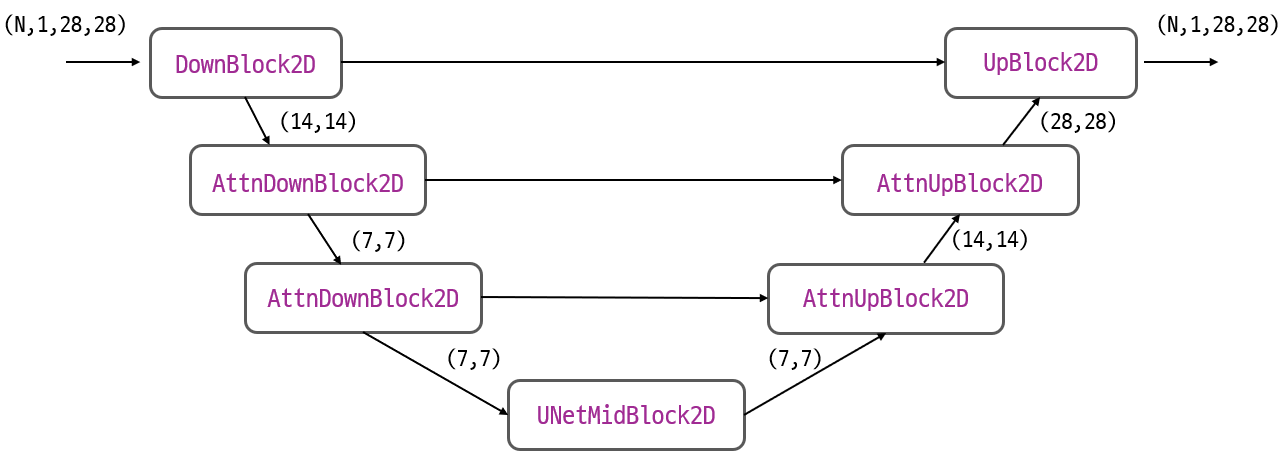

In [14]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=image_size,   # the target image resolution
    in_channels=1,            # the number of input channels, 3 for RGB images
    out_channels=1,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)
model.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

### Parameter 개수

In [15]:
sum([p.numel() for p in model.parameters()])

1707009

### Forward Test

- 위에서 만든 노이즈로 뭉개진 8개 이미지 `noisy_xb`를 입력하면 각 이미지에 대한 예측 노이즈가 반환

- 반횐 텐서 크기가 `(8,1,28,28)`임을 확인


In [16]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample

model_prediction.shape

torch.Size([8, 1, 28, 28])

## Step 5: Create a Training Loop

- 모델과 스케쥴러가 있을 뿐 학습은 일반적인 pytorch 학습 루프와 동일

- 단 모델에 샘플 미니배치를 입력하기전에 미니배치에 노이즈를 주입하는 과정을 추가

In [17]:
# Training loop
# optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

epochs = 15
losses = []
print_epoch = 1

for epoch in range(epochs):
    for step, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        # sample images without noise
        clean_images = batch[0].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        #  0 ~ 999 타입 스탭 숫자 bs개 샘플링
        # 각 이미지에 각기 다른 타입스탭을 지정하여 그에 따른 노이즈를 준다.
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps).sample

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()

    if (epoch + 1) % print_epoch == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:1, loss: 0.06694193402015323


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:2, loss: 0.03729273563524935


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:3, loss: 0.033401161579212656


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:4, loss: 0.031102250181217945


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:5, loss: 0.029725020477321864


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:6, loss: 0.02801620626230357


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:7, loss: 0.027678823662496833


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:8, loss: 0.0268726241407491


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:9, loss: 0.026092046359454644


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:10, loss: 0.02571835858957854


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:11, loss: 0.02548308027530911


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:12, loss: 0.025001302099367705


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:13, loss: 0.02492009059611414


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:14, loss: 0.024582463683985444


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch:15, loss: 0.02435166732286975


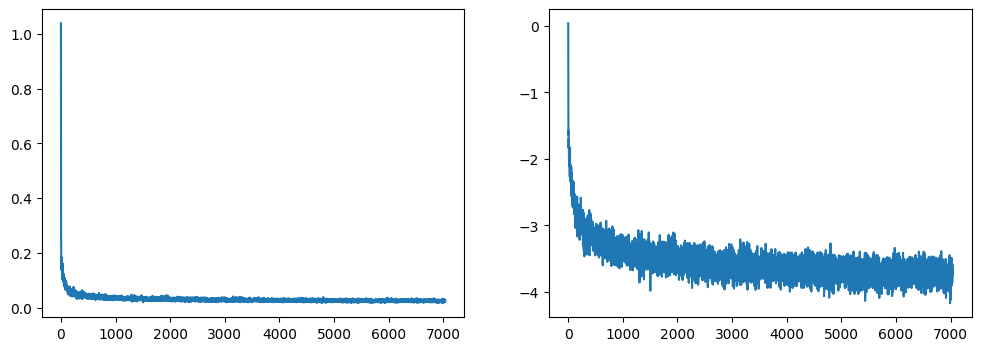

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

- 학습된 모델로부터 이미지를 얻기 위해서 두가지 선택 존재

- Option 1은 학습된 모델과 스케쥴러를 `DDPMPipeline` 파이브라인에 공급하고 파이프라인을 실행하여 이미지 생성

### Option 1: Creating a pipeline:

In [19]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [20]:
pipeline_output = image_pipe()
pipeline_output.images[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Option 2: Writing a Sampling Loop

- 두번째 방식은 직접 샘플링 루프를 구현


  0%|          | 0/1000 [00:00<?, ?it/s]

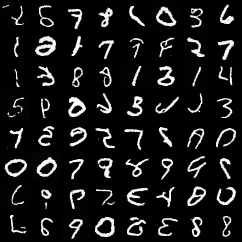

In [22]:
# Random starting point (64 random images):
sample = torch.randn(64, 1, 28, 28).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    # prev_sample: x_{t-1}
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [ ]:
# 2024.11.14 t4에서 테스트 완료

# 이 파일 이후에 나비 데이터 학습 실습